## Project Description

## Setting up Environment

#### Mount Google Drive

Start the notebook by mounting the Google Drive to access the data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

#email: MIDS.W251@gmail.com
#password MIDS.W2511234

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


#### Dataset 

https://www.kaggle.com/hgunraj/covidxct?select=2A_images \
https://www.kaggle.com/hgunraj/covidx-ct-starter-code


## Libraries

In [ ]:
# Import the data science stack
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import re
import scipy

from sklearn.utils import shuffle

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Image importing
import csv
import cv2


## Data Preprocessing

#### Images

In [ ]:
# Importing Pickle files to recreate Numpy Array
array_list = []
for i in range(0, 1):
  array_list.append(pd.read_pickle('./image_df_'+str(i+1)+'.pkl'))

image_df = pd.concat(array_list)

array_list = []

In [ ]:
# Dataframe with classes
image_col_list = list(image_df.columns[:65536])
data_model = image_df[image_col_list]

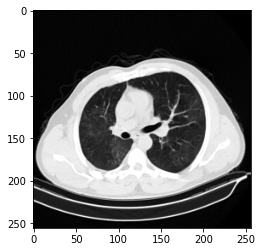

In [ ]:
# Sample CT scan
plt.imshow(np.reshape(np.array(data_model.iloc[0]), (256,256)), cmap='gray')

In [ ]:
# Size of the images: 256x256=65536
data_model.shape

(21658, 65536)

#### Classes and Bounding Boxes 

In [ ]:
# Read in train, validation, and test
train_labels = pd.read_csv('train_COVIDx_CT-2A.txt', sep=' ',
                         names=['image_id','class','xmin', 'ymin', 'xmax', 'ymax'])
val_labels = pd.read_csv('val_COVIDx_CT-2A.txt', sep=' ',
                         names=['image_id','class','xmin', 'ymin', 'xmax', 'ymax'])
test_labels = pd.read_csv('test_COVIDx_CT-2A.txt', sep=' ',
                         names=['image_id','class','xmin', 'ymin', 'xmax', 'ymax'])
train_labels.head()

,image_id,class,xmin,ymin,xmax,ymax
0,NCP_96_1328_0032.png,2,9,94,512,405
1,NCP_96_1328_0035.png,2,10,106,512,405
2,NCP_96_1328_0036.png,2,10,105,512,406
3,NCP_96_1328_0037.png,2,11,104,512,406
4,NCP_96_1328_0038.png,2,11,103,512,406


In [ ]:
train_labels.shape

(143778, 6)

#### Combine labels and images

In [ ]:
# Join the dataframes based on image name
mini_train = image_df.set_index('index').join(train_labels.set_index('image_id'), how='inner')
mini_val = image_df.set_index('index').join(val_labels.set_index('image_id'), how='inner')

In [ ]:
print('mini train dataset')
print(mini_train.shape)

print()
print('mini val dataset')
print(mini_val.shape)

mini train dataset
(12950, 65541)

mini val dataset
(3771, 65541)


In [ ]:
# Mini dataset used for training
X_train = mini_train[image_col_list]
y_train = mini_train['class']


In [ ]:
# Mini dataset used for validation
X_val = mini_val[image_col_list]
y_val = mini_val['class']


## EDA

The following is for the full train dataset

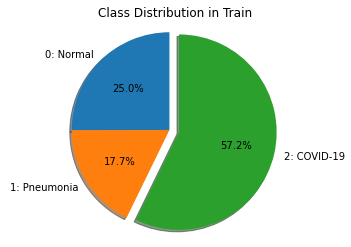

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '0: Normal', '1: Pneumonia', '2: COVID-19'
sizes = [np.sum(train_labels['class']==0)/len(train_labels), 
         np.sum(train_labels['class']==1)/len(train_labels), 
         np.sum(train_labels['class']==2)/len(train_labels)]

explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Class Distribution in Train')
plt.show()

The majority class in the train dataset is COVID-19, 57%.  For classification, we may need to handle the class imbalance by using ROC AUC score.  

Additionally, the application of GAN may be used to 'up-sample' the pneumonia cases.

The following is for the mini dataset

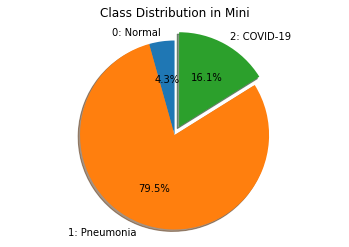

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '0: Normal', '1: Pneumonia', '2: COVID-19'
sizes = [np.sum(y_train == 0)/len(y_train), 
         np.sum(y_train == 1)/len(y_train), 
         np.sum(y_train == 2)/len(y_train)]

explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Class Distribution in Mini')
plt.show()

## Data set for Training in Collab

You may use X_train, y_train, X_val, y_val for now - [Simon 3/7/2021]

# cGAN - David Yen

### Data augmentation
Import statements

In [ ]:
from tensorflow.keras import layers

Data augmentation for underrepresented classes (Normal and COVID-19) in mini dataset

In [ ]:
# Convert to numpy arrays and reshape training and validation dataframes
n_sample=2048
X_np_train = np.array(X_train.iloc[0:n_sample]).reshape(X_train.iloc[0:n_sample].shape[0], 256, 256, 1).astype('float32')
y_np_train = np.array(y_train.iloc[0:n_sample]).astype('int32')

X_np_val = np.array(X_val.iloc[0:n_sample]).reshape(X_val.iloc[0:n_sample].shape[0], 256, 256, 1).astype('float32')
y_np_val = np.array(y_val.iloc[0:n_sample]).astype('int32')

#X_np_test = np.array(X_test.iloc[0:n_sample]).reshape(X_test.iloc[0:n_sample].shape[0], 256, 256, 1).astype('float32')
#y_np_test = np.array(y_test.iloc[0:n_sample]).astype('int32')

In [ ]:
print(X_np_train.shape)
print(y_np_train.shape)

(2048, 256, 256, 1)
(2048,)


In [ ]:
train_ds = (tf.data.Dataset.from_tensor_slices((X_np_train, y_np_train)))

val_ds = (tf.data.Dataset.from_tensor_slices((X_np_val, y_np_val)))

In [ ]:
print(train_ds)
print(val_ds)

<TensorSliceDataset shapes: ((256, 256, 1), ()), types: (tf.float32, tf.int32)>
<TensorSliceDataset shapes: ((256, 256, 1), ()), types: (tf.float32, tf.int32)>


In [ ]:
batch_size = n_sample
imsize = 256
AUTOTUNE = tf.data.AUTOTUNE

resize = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(imsize,imsize),                             
  layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  #layers.experimental.preprocessing.RandomRotation(0.2),
])

def prepare(ds, shuffle=False, augment=False):
  # Resize all datasets
  ds = ds.map(lambda x, y: (resize(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(n_sample)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use cache and buffered prefetching on all datasets
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# test_ds should be replaced with test data set
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
#test_ds = prepare(test_ds)

In [ ]:
# Inspect batch size of augmented data sets
i = 0
for image_batch, labels_batch in train_ds:
  print(i)
  print(image_batch.shape)
  print(labels_batch.shape)
  i += 1

i = 0
for image_batch, labels_batch in val_ds:
  print(i)
  print(image_batch.shape)
  print(labels_batch.shape)
  i += 1

0
(2048, 256, 256, 1)
(2048,)
0
(2048, 256, 256, 1)
(2048,)


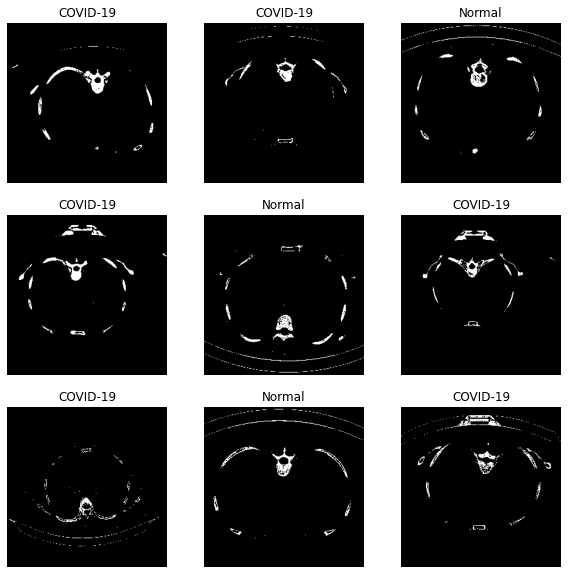

In [ ]:
class_names = ['Normal', 'Pneumonia',  'COVID-19']

# Plot 9 augmented images from training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap='gray')
    #plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

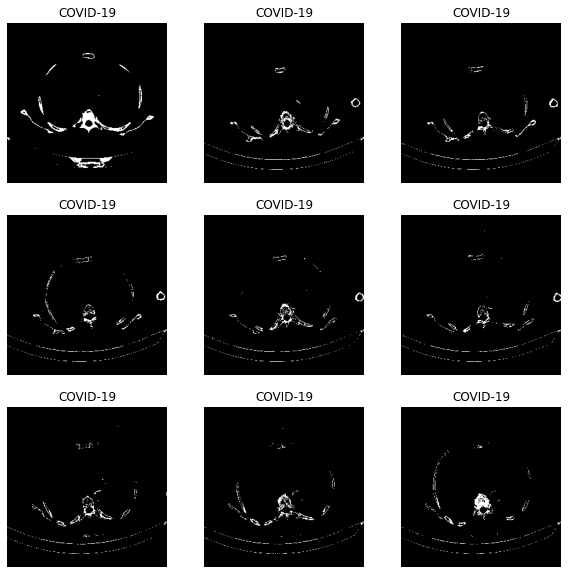

In [ ]:
# Plot 9 augmented images from validation dataset
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap='gray')
    #plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

Code below creates data augmentation layer for direct inclusion in the model, code adapted from https://www.tensorflow.org/tutorials/images/classification#data_augmentation

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

### Conditional GAN
cGAN example taken from https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

In [ ]:
# example of training an conditional gan on the fashion mnist dataset
from os import makedirs
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import random
from numpy.random import randn
from numpy.random import randint
from numpy.random import choice
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
from PIL import Image
 
# define the standalone discriminator model
def define_discriminator(in_shape=(imsize,imsize,1), n_classes=3):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # label input
  in_label = Input(shape=(1,))
	# embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
  n_nodes = in_shape[0] * in_shape[1]
  li = Dense(n_nodes)(li)
	# reshape to additional channel
  li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
  in_image = Input(shape=in_shape)
	# concat label as a channel
  merge = Concatenate()([in_image, li])
	# downsample to 128x128
  fe = Conv2D(128/4, (5,5), kernel_initializer=init, strides=(2,2), padding='same')(merge)
  #fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
	# downsample to 64x64
  fe = Conv2D(128/2, (5,5), kernel_initializer=init, strides=(2,2), padding='same')(fe)
  #fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
	# downsample to 32x32
  fe = Conv2D(128, (5,5), kernel_initializer=init, strides=(2,2), padding='same')(fe)
  #fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
	# downsample to 16x16
  fe = Conv2D(128*2, (5,5), kernel_initializer=init, strides=(2,2), padding='same')(fe)
  #fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
	# downsample to 8x8
  fe = Conv2D(128*4, (5,5), kernel_initializer=init, strides=(2,2), padding='same')(fe)
  #fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # flatten feature maps
  fe = Flatten()(fe)
	# dropout
  fe = Dropout(0.4)(fe)
	# output
  out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
  model = Model([in_image, in_label], out_layer)
	# compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model
 
# define the standalone generator model
def define_generator(latent_dim, n_classes=3):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # label input
  in_label = Input(shape=(1,))
	# embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
  n_nodes = 8 * 8
  li = Dense(n_nodes)(li)
	# reshape to additional channel
  li = Reshape((8, 8, 1))(li)
	# image generator input
  in_lat = Input(shape=(latent_dim,))
	# foundation for 8x8 image
  n_nodes = 128*4 * 8 * 8
  gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((8, 8, 128*4))(gen)
	# merge image gen and label input
  merge = Concatenate()([gen, li])
	# upsample to 16x16
  gen = Conv2DTranspose(128*2, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
  #gen = BatchNormalization()(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 32x32
  gen = Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
  #gen = BatchNormalization()(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # upsample to 64x64
  gen = Conv2DTranspose(128/2, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
  #gen = BatchNormalization()(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # upsample to 128x128
  gen = Conv2DTranspose(128/4, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
  #gen = BatchNormalization()(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # upsample to 256x256
  gen = Conv2DTranspose(128/8, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
  #gen = BatchNormalization()(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # output
  out_layer = Conv2D(1, (8,8), activation='tanh', padding='same', kernel_initializer=init)(gen)
	# define model
  model = Model([in_lat, in_label], out_layer)
  return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# load CT-scan (#fashion mnist) images
def load_real_samples():
  #X = X_np_train
  #trainy = y_np_train
  # load dataset
  #(trainX, trainy), (_, _) = load_data()
  # expand to 3d, e.g. add channels
  #X = expand_dims(trainX, axis=-1)
  # convert from ints to floats
  #X = X.astype('float32')
  # scale from [0,255] to [-1,1]
  #X = (X - 127.5) / 127.5
  #trainX, trainy = tuple(zip(*train_ds))
  i = 0
  for trainX, trainy in train_ds:
    print(i)
    print(trainX.shape)
    print(trainy.shape)
    i += 1
  #X = (trainX - 127.5) / 127.5
  #X = tf.shape(tf.squeeze(trainX, axis=0))
  #trainy = tf.shape(tf.squeeze(trainy, axis=0))
  return [np.array(trainX), np.array(trainy)]
 
# randomly flip some labels
def noisy_labels(y, p_flip):
	# determine the number of labels to flip
	n_select = int(p_flip * y.shape[0])
	# choose labels to flip
	flip_ix = choice([i for i in range(y.shape[0])], size=n_select)
	# invert the labels in place
	y[flip_ix] = 1 - y[flip_ix]
	return y 

# label smoothing examples: smooth_positive_labels(y) and smooth_negative_labels(y)
# example of smoothing class=1 to [0.7, 1.2]
def smooth_positive_labels(y):
	return y - 0.3 + (random(y.shape) * 0.5)

# example of smoothing class=0 to [0.0, 0.3]
def smooth_negative_labels(y):
	return y + random(y.shape) * 0.3 

# # select real samples
def generate_real_samples(dataset, n_samples):
  # split into images and labels
  images, labels = dataset
  # choose random instances
  ix = randint(0, images.shape[0], n_samples)
  # select images and labels
  X, labels = images[ix], labels[ix]
  # generate class labels
  y = ones((n_samples, 1))
  # flip labels with 5% probability
  y = noisy_labels(y, 0.05)
  # summarize labels
  #print(y.sum())
  # smooth labels (*** does not help)
  #y = np.where(y==1, smooth_positive_labels(y), smooth_negative_labels(y))
  # summarize smooth labels
  #print(y.shape, y.min(), y.max())    
  return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=3):
	# generate n_samples random Gaussian points from in a vector of latent_dim space 
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  images = generator.predict([z_input, labels_input])
  # create class labels
  y = zeros((n_samples, 1))
  # flip labels with 5% probability
  y = noisy_labels(y, 0.05)
  # summarize labels
  #print(y.sum()) 
  # smooth labels (*** does not help)
  #y = np.where(y==1, smooth_positive_labels(y), smooth_negative_labels(y))
  # summarize smooth labels
  #print(y.shape, y.min(), y.max())    
  return [images, labels_input], y


# generate sample images and save plots and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	Z, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (Z[0] + 1.0) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	pyplot.savefig('results1e2_baseline/generated_plot_%03d.png' % (step+1))
	pyplot.close()
	# save the generator model
	#g_model.save('results1e2_baseline/model_%03d.h5' % (step+1))
 
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
	# plot loss
	pyplot.subplot(2, 1, 1)
	pyplot.plot(d1_hist, label='d-real')
	pyplot.plot(d2_hist, label='d-fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	# plot discriminator accuracy
	pyplot.subplot(2, 1, 2)
	pyplot.plot(a1_hist, label='acc-real')
	pyplot.plot(a2_hist, label='acc-fake')
	pyplot.legend()
	# save plot to file
	pyplot.savefig('results1e2_baseline/plot_line_plot_loss.png')
	pyplot.close()
  
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=60, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # calculate the total iterations based on batch and epoch
  n_steps = bat_per_epo * n_epochs
	# prepare lists for storing stats each iteration
  d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
	# manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
			# get randomly selected 'real' samples
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
      d_loss1, d_acc1 = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
      d_loss2, d_acc2 = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # flip labels with 5% probability
      y_gan = noisy_labels(y_gan, 0.05)
      # smooth labels (***does not help)
      #y_gan = np.where(y_gan==1, smooth_positive_labels(y_gan), smooth_negative_labels(y_gan))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f, a1=%d, a2=%d' %
        (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss, int(100*d_acc1), int(100*d_acc2)))
      # record history
      d1_hist.append(d_loss1)
      d2_hist.append(d_loss2)
      g_hist.append(g_loss)
      a1_hist.append(d_acc1)
      a2_hist.append(d_acc2)
      # evaluate the model performance every 'epoch'
      if (i*bat_per_epo+j+1) % bat_per_epo == 0:
        summarize_performance(i*bat_per_epo+j, g_model, latent_dim)
  plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)
    
  # save the generator model
  g_model.save('cgan1e2_generator.h5')
 
# make folder for results
makedirs('results1e2_baseline', exist_ok=True)
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

0
(2048, 256, 256, 1)
(2048,)
>1, 1/16, d1=0.692, d2=0.697 g=0.692, a1=56, a2=4
>1, 2/16, d1=0.564, d2=0.697 g=0.693, a1=95, a2=4
>1, 3/16, d1=0.312, d2=0.697 g=0.697, a1=95, a2=4
>1, 4/16, d1=0.222, d2=0.687 g=0.707, a1=95, a2=95
>1, 5/16, d1=0.200, d2=0.676 g=0.727, a1=95, a2=95
>1, 6/16, d1=0.188, d2=0.650 g=0.783, a1=95, a2=96
>1, 7/16, d1=0.185, d2=0.596 g=0.941, a1=95, a2=95
>1, 8/16, d1=0.201, d2=0.457 g=1.614, a1=95, a2=95
>1, 9/16, d1=0.197, d2=0.247 g=2.712, a1=95, a2=95
>1, 10/16, d1=0.373, d2=0.188 g=3.153, a1=95, a2=95
>1, 11/16, d1=0.492, d2=0.201 g=2.248, a1=84, a2=95
>1, 12/16, d1=0.360, d2=0.218 g=2.374, a1=95, a2=95
>1, 13/16, d1=0.222, d2=0.201 g=2.731, a1=95, a2=95
>1, 14/16, d1=0.206, d2=0.191 g=3.073, a1=95, a2=95
>1, 15/16, d1=0.189, d2=0.138 g=3.213, a1=95, a2=96
>1, 16/16, d1=0.197, d2=0.187 g=3.067, a1=95, a2=95
>2, 1/16, d1=0.139, d2=0.191 g=2.948, a1=96, a2=95
>2, 2/16, d1=0.197, d2=0.190 g=2.823, a1=95, a2=95
>2, 3/16, d1=0.193, d2=0.192 g=2.903, a1=95, a2=

In [ ]:
# Inspect batch size and dimensions of the dataset
images_train, labels_train = dataset
print(images_train.shape)
print(labels_train.shape)

(2048, 256, 256, 1)
(2048,)


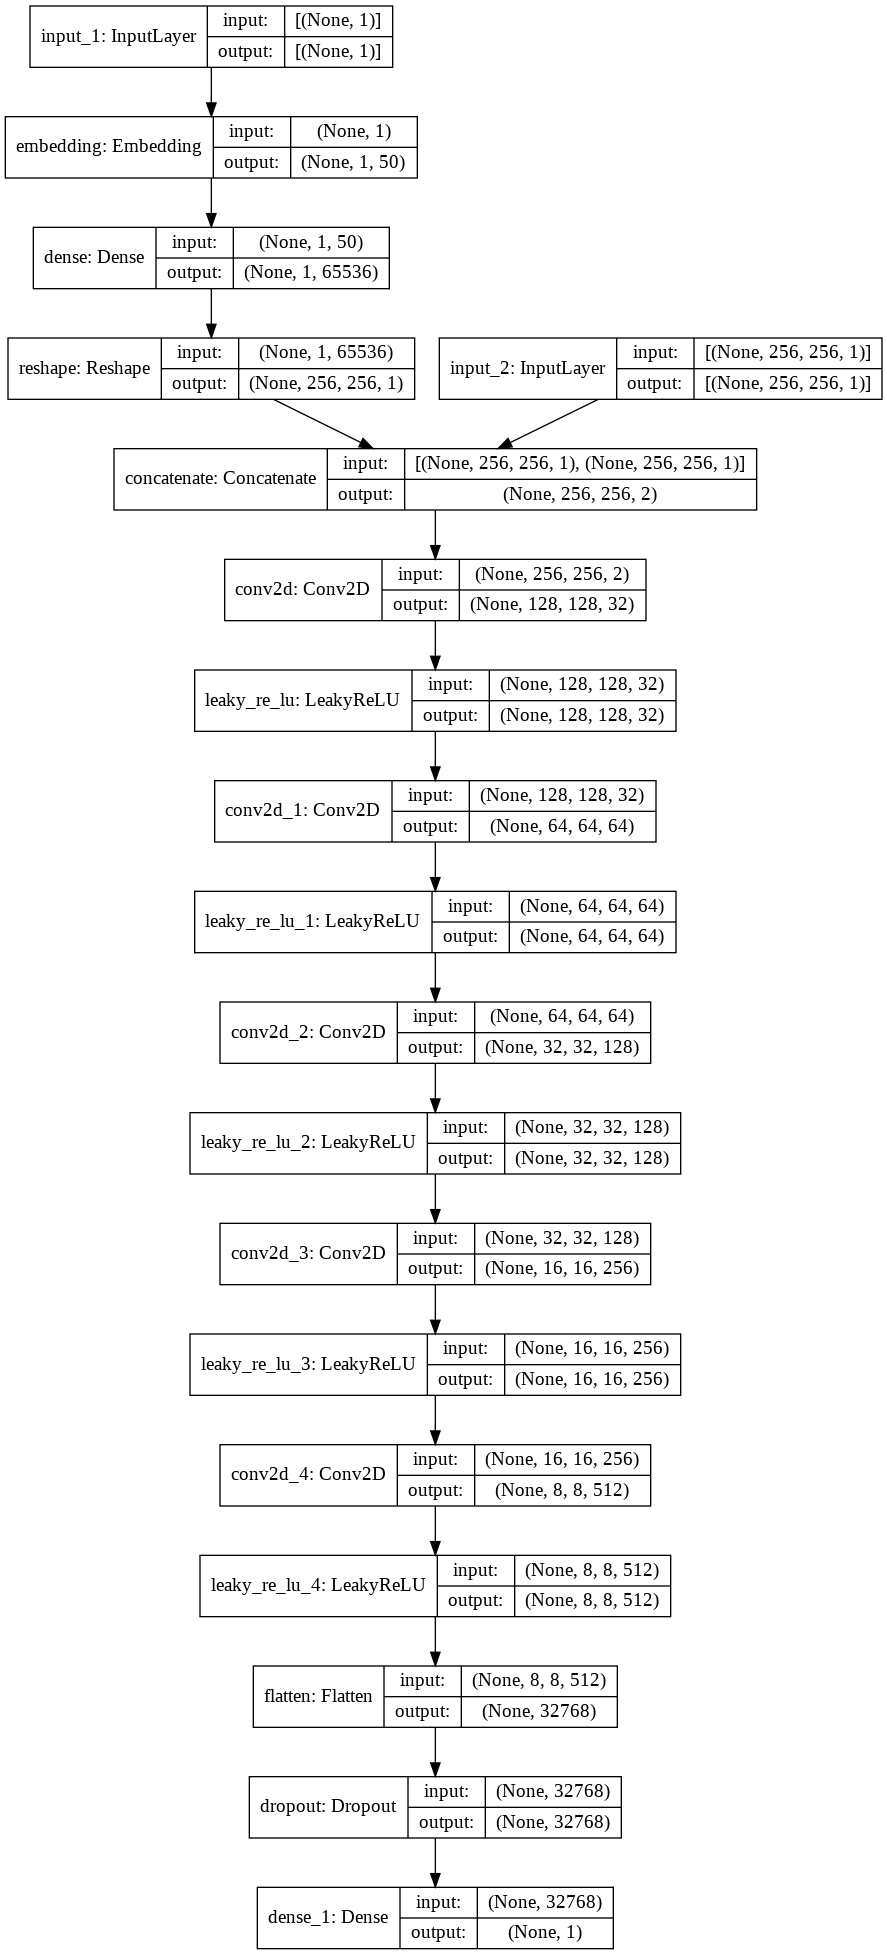

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(d_model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)

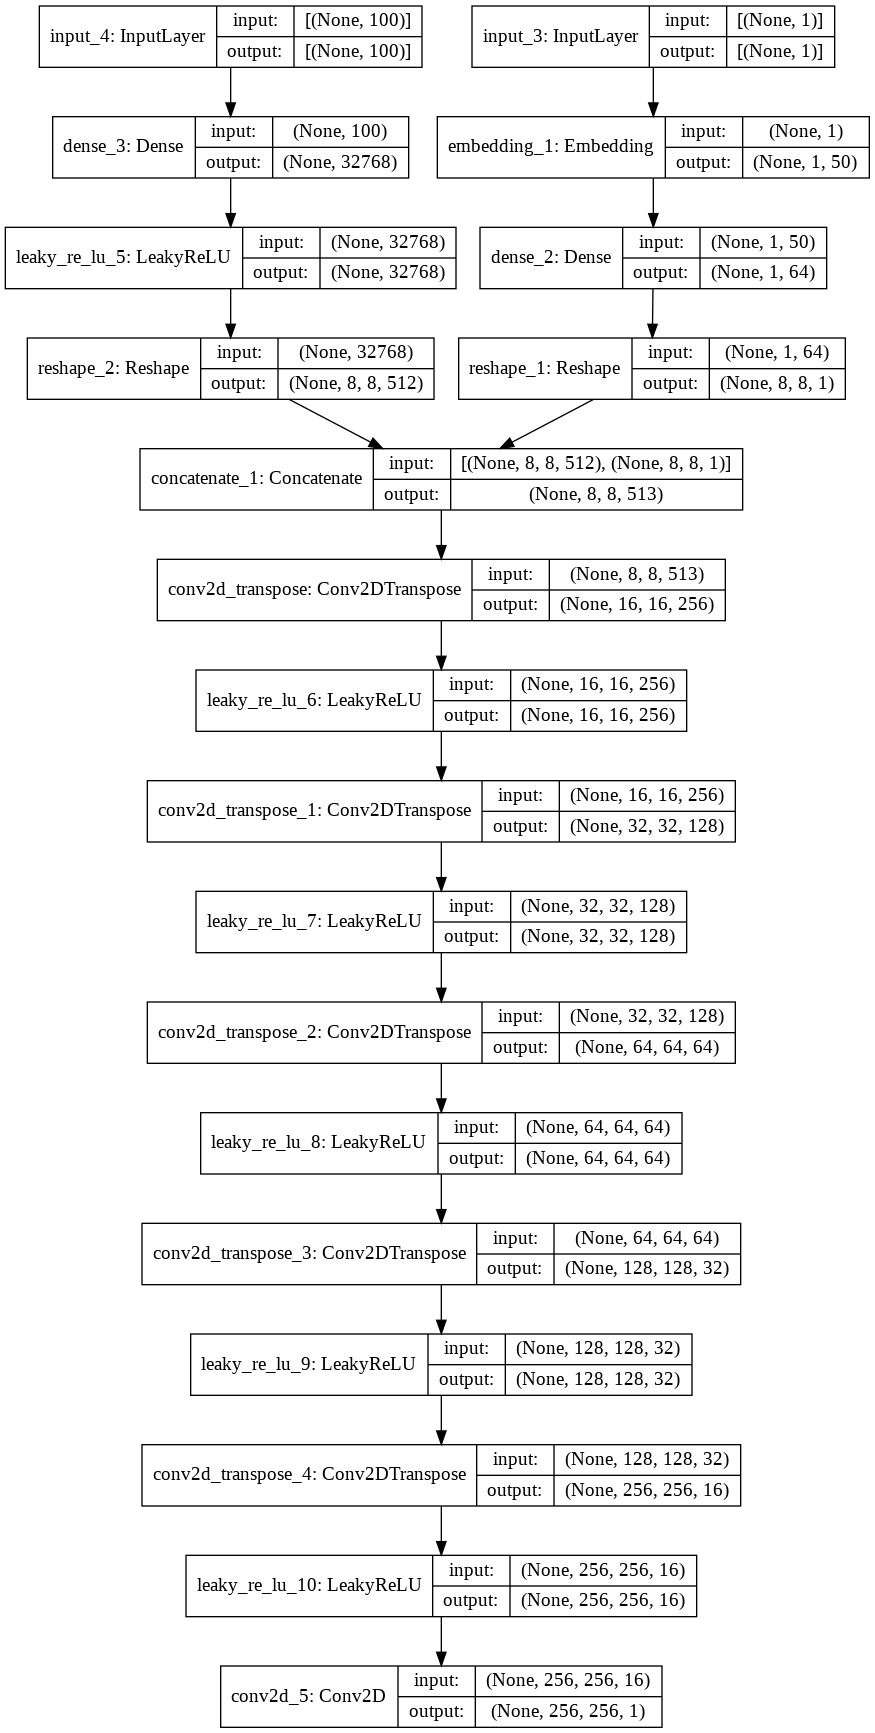

In [ ]:
plot_model(g_model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)

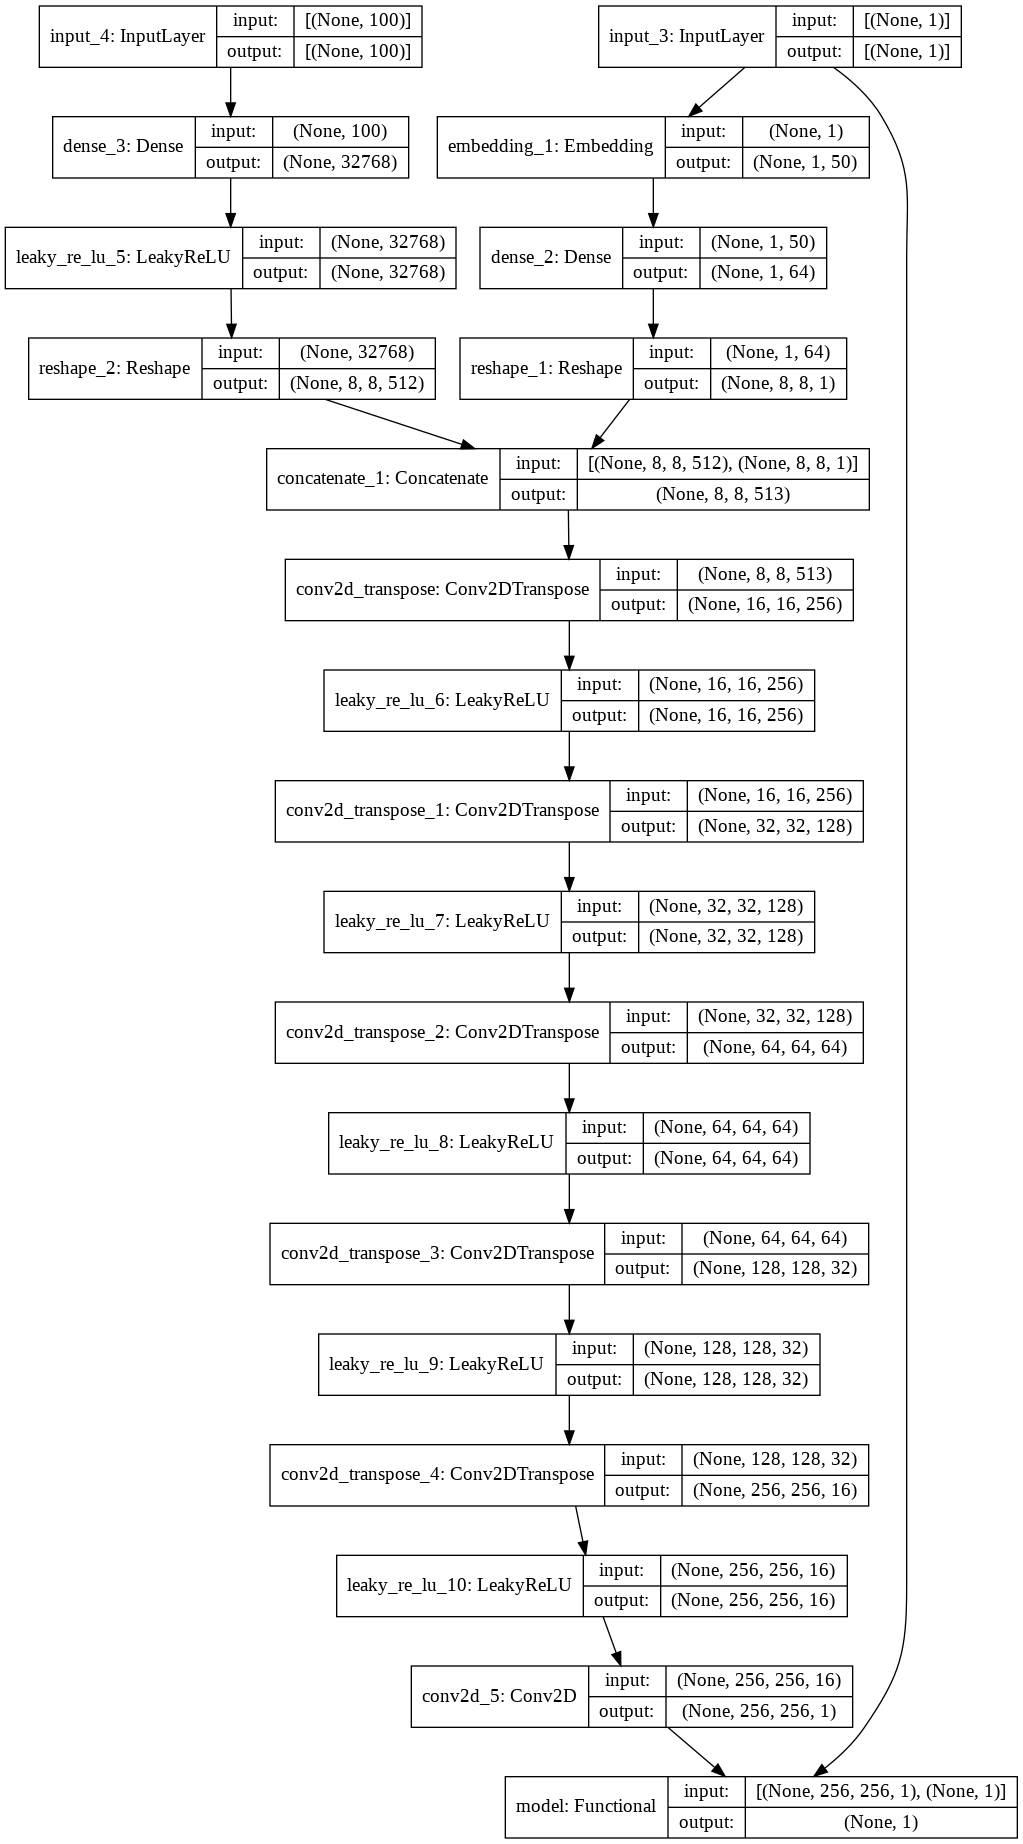

In [ ]:
plot_model(gan_model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)

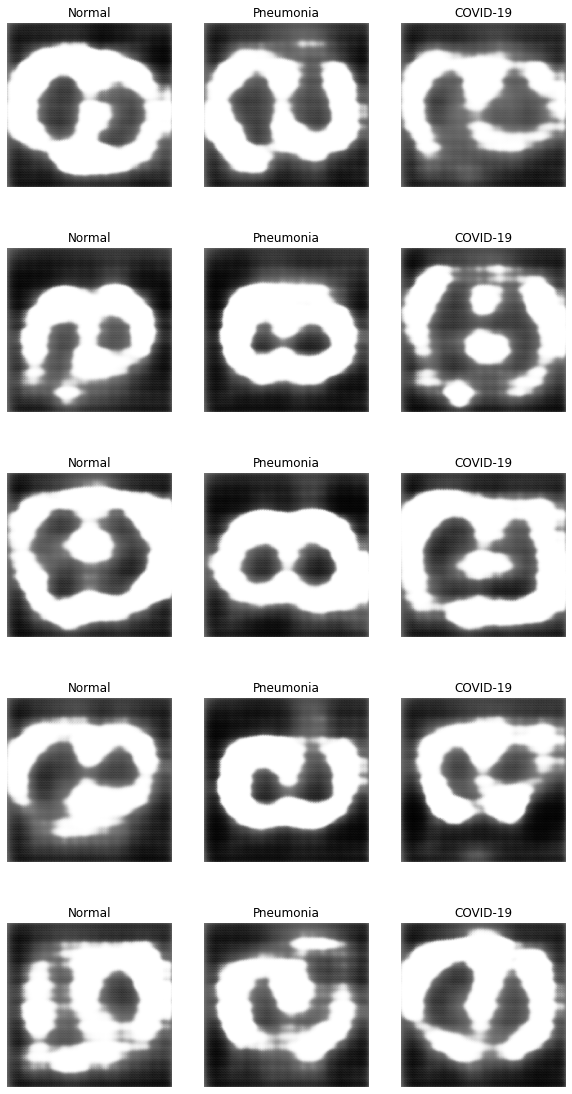

In [ ]:
# example of loading the generator model and generating images
from numpy import asarray
from keras.models import load_model
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot

# create and save a plot of generated images
def save_plot(examples, n):
  # plot images
  for i in range(n * 3):
    # define subplot
    pyplot.subplot(n, 3, 1 + i)
    # turn off axis and print label as title for each image
    pyplot.axis('off')
    pyplot.title(class_names[labels[i]])
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
  pyplot.show()
 
# load model
model = load_model('cgan1e2_generator.h5')
#model = load_model('cgan1e3_1600_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 15)
# specify labels
labels = asarray([x for _ in range(5) for x in range(3)])
# generate images
X  = - model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
class_names = ['Normal', 'Pneumonia',  'COVID-19']
pyplot.figure(figsize=(10, 20))
save_plot(X, 5)

Code below from Simon

In [ ]:
# grap a small portion of the data 
# note crashes if trying to reshape entire dataset
mini_train_images = np.array(data_model.iloc[0:1000])

In [ ]:
# reshape images to 256x256
mini_train_images = mini_train_images.reshape(mini_train_images.shape[0], 256, 256, 1).astype('float32')

In [ ]:
mini_train_images.shape
# should be (1000, 256, 256, 1)

(1000, 256, 256, 1)

In [ ]:
# reshape images to 256x256
# mini_train_images = mini_train_images.reshape(mini_train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (mini_train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

discriminator = make_discriminator_model()
decision = discriminator(generated_image)

### Loss functions 

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss: This method quantifies how well the discriminator is 
# able to distinguish real images from fakes. It compares the discriminator's predictions 
# on real images to an array of 1s, and the discriminator's 
# predictions on fake (generated) images to an array of 0s.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# The generator's loss quantifies how well it was able to trick the discriminator. 
# Intuitively, if the generator is performing well, the discriminator will classify 
# the fake images as real (or 1). Here, we will compare the discriminators decisions 
# on the generated images to an array of 1s.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizers

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
import os
import time

### Checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Training Loop

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

#  Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
train(train_dataset, EPOCHS)

# References
1. Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, 2015, Alec Radford, Luke Metz, Soumith Chintala 
https://arxiv.org/abs/1511.06434
2. How to Train a GAN? Tips and tricks to make GANs work, 2016, Soumith Chintala, Emily Denton, Martin Arjovsky, Michael Mathieu
https://github.com/soumith/ganhacks